In [18]:
from keras.applications import VGG16

conv_base = VGG16(
    weights = 'imagenet', #指定模型初始化的权重检查点
    include_top = False, #指定模型最后是否包含密集连接分类器（Dense）层，VGG16是1000个类别，本次预测猫狗的话，是2各类别，所以不使用
    input_shape = (150,150,3) #输入到网络中的张量形状，这个可以不用输入，能够自动检测
)
conv_base.summary() #注意最后返回的特征图形状

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [19]:
#不使用数据增强的快速特征提取
#使用预训练的卷积基提取特征

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_small_dir = 'D:/data/cat-dog/small_samples'
train_dir = os.path.join(base_small_dir, 'train')
validation_dir = os.path.join(base_small_dir, 'validation')
test_dir = os.path.join(base_small_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150,150),
        batch_size = batch_size,
        class_mode = 'binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count: #因为生成器是一直生成，所以必须添加中断点
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
#目前提取的特征形状均为（样本数，4，4，512）。如果要输入到密集连接分类器中时，必须转换（展平）为形状（样本数，4*4*512）

train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [9]:
train_features.shape

(2000, 8192)

In [21]:
#定义并训练密集连接分类器

from keras import models
from keras.layers import Dense, Dropout
from keras import optimizers

model = models.Sequential()
model.add(Dense(256, activation = 'relu', input_dim = 512*4*4,))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs = 30,
    batch_size = 20,
    validation_data= (validation_features, validation_labels)
)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6031 - acc: 0.6635 - val_loss: 0.4379 - val_acc: 0.8460
Epoch 2/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.4170 - acc: 0.8135 - val_loss: 0.3656 - val_acc: 0.8540
Epoch 3/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3502 - acc: 0.8515 - val_loss: 0.3213 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3129 - acc: 0.8715 - val_loss: 0.3013 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2782 - acc: 0.8870 - val_loss: 0.2854 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2638 - acc: 0.8945 - val_loss: 0.2734 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2442 - acc: 0.9075 - val_loss: 0.2723 - val_acc: 0.8900
Epoch 8/30
200

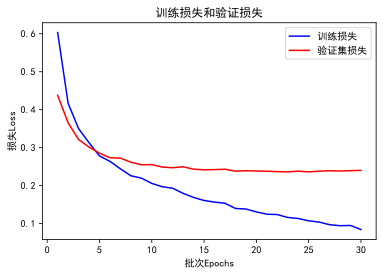

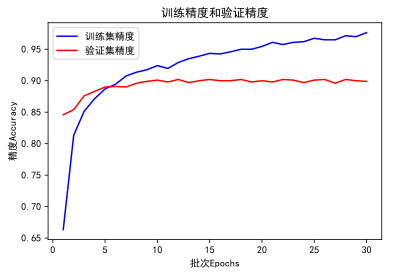

In [22]:
#画图精度和损失对比

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg' #画的图更清晰

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs, loss_values,'b',label='训练损失') 
plt.plot(epochs, val_loss_values,'r',label='验证集损失') 
plt.title('训练损失和验证损失')
plt.xlabel('批次Epochs')
plt.ylabel('损失Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc,'b',label='训练集精度') 
plt.plot(epochs, val_acc,'r',label='验证集精度') 
plt.title('训练精度和验证精度')
plt.xlabel('批次Epochs')
plt.ylabel('精度Accuracy')
plt.legend()

plt.show()

In [13]:
#使用数据增强的特征提取，注意没有显卡最好不要用这种方法
#和之前的区别是在Sequential模型中直接添加预训练模型，跟添加一个层一样

from keras import models
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
#冻结卷积基
conv_base.trainable = False

In [ ]:
#训练模型，和猫狗模型一样

from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1/255, #对图片的每个像素值均乘上这个放缩因子，把像素值放缩到0和1之间有利于模型的收敛
    rotation_range = 40, #角度值，0-180.表示图像随机旋转的角度范围
    width_shift_range = 0.2, #平移比例，下同
    height_shift_range = 0.2,
    shear_range = 0.2, #随机错切变换角度
    zoom_range = 0.2, #随即缩放比例
    horizontal_flip = True, #随机将一半图像水平翻转，主要用于真实世界的图像（即没有水平不对称的假设前提下）
    fill_mode='nearest' #填充新创建像素的方法
)

test_datagen = ImageDataGenerator(rescale=1/255) #注意验证集的数据不能增强



#训练模型，和上文的方法基本一样，只有训练批次增加了，正常应该是过拟合很严重的
train_generator = train_datagen.flow_from_directory(
    train_dir, #路径
    target_size = (150, 150), #图像大小
    batch_size = 20, #每批量样本大小
    class_mode = 'binary' #因为使用了binary_crossentropy损失函数，所以用二进制标签
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size = (150, 150), 
    batch_size = 20, 
    class_mode = 'binary' 
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100, 
    epochs = 30, 
    validation_data = validation_generator, 
    validation_steps = 50 
)

In [15]:
#模型微调
conv_base.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [17]:
for layer in conv_base.layers:
    print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
#冻结直到某一层的所有层

conv_trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'bloc5_conv1': #这层之后的所有层解冻，包含该层
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100, 
    epochs = 100, #增加了训练批次
    validation_data = validation_generator, 
    validation_steps = 50 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

#test_loss, test_acc = model.evaluate_generator(test_generator, steps = 96)
print(model.evaluate_generator(test_generator, steps = 96))
#print(test_loss, test_acc)